**Seguimiento 4**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#cargar datos
import os 
ruta=os.getcwd()
archivo=os.listdir(ruta+'/EMG_data_for_gestures-master')
serie1=[] #guardar en matriz tridimensional? para no tener dos series por aparte
serie2=[]
for i in archivo[0:-1]: #ignora el readme
    v=os.listdir(ruta+'/EMG_data_for_gestures-master'+'/'+i)
    #x1=np.loadtxt(ruta+'/EMG_data_for_gestures-master'+'/'+i+'/'+v[0],skiprows=1,delimiter='\t',usecols=range(0,9))
    x2=np.loadtxt(ruta+'/EMG_data_for_gestures-master'+'/'+i+'/'+v[1],skiprows=1,delimiter='\t',usecols=range(0,10))
    #serie1.append(x1)
    serie2.append(x2)
#serie1=np.array(serie1,dtype=object)
#serie2=np.array(serie2,dtype=object)
#serie1[0] -->Serie 1 del primer sujeto y no carga la columna class porque el ultimo dato de la serie 1 del sujeto 34 le falta el valor (creo que es por eso)
#se podría arreglar skipeando también la última fila. o cargando solo los 2 xd

definicion de funciones

In [4]:
def tkeo(data): 
    x=data*1
    x[1:-1]=np.square(x[1:-1])-np.multiply(x [0:-2],x[2:]) #aplica la función para todos los datos menos el primero y el último, que no es un problema (describir en análisis)
    return x

In [5]:
def tkeoall(xdata): #se le entrega la matriz incluyendo la columna del tiempo (no la de class)
    data=xdata[:,1:-1]*1
    tkeoforchannel=np.apply_along_axis(tkeo,0,data)
    return tkeoforchannel #saca un array donde tkeoall(data)[0] es el primer canal

In [6]:
def rms(x): #x es un array
    x_squared=np.square(x)
    x_mean=np.mean(x_squared)
    xrms=np.sqrt(x_mean)
    return xrms

In [7]:
#funcion
def caracteristicas(data): 
    carac_canales=[]
    for i in range(0,np.shape(data)[1]): #tal vez se pueda usar apply_along_axis para calcular todas
        xx=data[:,i]
        xrms=rms(xx) #root mean square
        xvar=np.var(xx) #varianza
        xmav=np.mean(np.abs(data)) #mean absolute value
        xmavs=np.mean(np.abs(np.diff(data))) #mean absolute value slope
        derivative = np.diff(data)
        xssc = np.sum(np.diff(np.sign(derivative)) != 0) #Slope sign changes
        diff_abs = np.abs(np.diff(data))
        xwl = np.sum(diff_abs) #waveform length
        xzc = len(np.where(np.diff(np.sign(data)))[0]) #zero crossings
        carac_canal_actual=np.array([xrms,xvar,xmav,xmavs,xssc,xwl,xzc])
        carac_canales.append(carac_canal_actual)
    return np.array(carac_canales)

tkeo

In [8]:
tkeo_serie2=[]
for i in range(0,np.shape(serie2)[0]):
    tkeo_serie2.append((tkeoall(serie2[i]))) 

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


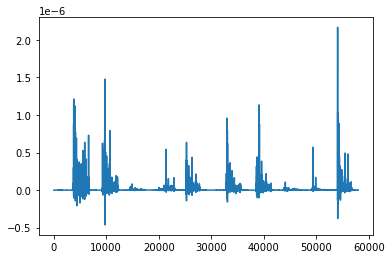

In [9]:
plt.plot(tkeo_serie2[0][:,0][1:-1])

separacion de movs

In [10]:
#Se separa de la señal con tkeo
movs=[]
for i in range(len(tkeo_serie2)):
    movsxsuj=[]
    for mov in range(7):
        mov_type=tkeo_serie2[i][serie2[i][:,-1]==mov]
        movsxsuj.append(mov_type) #lista con los 7 movs separados por cada sujeto
    movs.append(movsxsuj) #lista con todos los movs por sujeto

In [11]:
movs[0][1].shape

(3531, 8)

In [12]:
#guardar todos los tipos de movs en la misma lista
mov0=[] 
mov1=[]
mov2=[]
mov3=[]
mov4=[]
mov5=[]
mov6=[]
for suj in movs:
    mov0.append(suj[0])
    mov1.append(suj[1])
    mov2.append(suj[2])
    mov3.append(suj[3])
    mov4.append(suj[4])
    mov5.append(suj[5])
    mov6.append(suj[6])

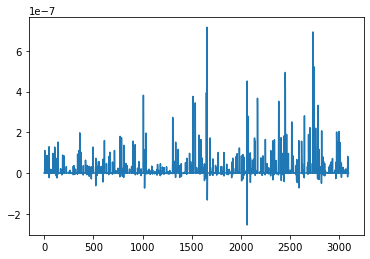

In [13]:
plt.plot(mov3[32][:,5]) #plotear canal 5 del movimiento tipo 3

caracteristicas

In [14]:
#calculo de caracteristicas promediadas por canales para cada sujeto (y movimiento)
#se ignora mov0 porque es un movimiento sin definir? -> revisar descripcion dataset
caracs1=[]
caracs2=[]
caracs3=[]
caracs4=[]
caracs5=[]
caracs6=[]
for i in range(len(mov1)):
    caracs1.append(np.mean(caracteristicas(mov1[i]),axis=0))
    caracs2.append(np.mean(caracteristicas(mov2[i]),axis=0))
    caracs3.append(np.mean(caracteristicas(mov3[i]),axis=0))
    caracs4.append(np.mean(caracteristicas(mov4[i]),axis=0))
    caracs5.append(np.mean(caracteristicas(mov5[i]),axis=0))
    caracs6.append(np.mean(caracteristicas(mov6[i]),axis=0))
#orden : [xrms,xvar,xmav,xmavs,xssc,xwl,xzc] (columnas)

In [15]:
caracs6[35]

array([1.12766793e-08, 1.75336854e-16, 2.32375560e-09, 3.20258826e-09,
       2.13200000e+03, 7.00342000e-05, 1.73100000e+03])

filtro

Se proponen diseñar dos filtros conforme lo visto en proyectos anteriores: filtro notch a 60 Hz para mitigar ruido eléctrico (aunque seguramente el myo thalmic ya lo haga) y un filtro pasa altas a 10 Hz (según literatura frecuencias de interés en EMG 10-500? Hz). El brazalete myo thalmic tiene una frecuencia de muestreo de 200 Hz, por lo tanto el rango de frecuencias obtenidas después de filtrar sería de 10 a 100 Hz menos el ruido eléctrico en 60 Hz.

diseño

In [16]:
#coeficientes de los filtros
import scipy.signal as signal
fs=200 #freq muestreo myo thalmic
b_high = signal.firwin(20+1, 10/(fs/2), pass_zero='highpass') #orden 20
b_notch= signal.firwin(30+1, (55/(fs/2),65/(fs/2)), pass_zero='bandstop') #orden 30

Se decide utilizar filtros FIR debido a su estabilidad de fase, que en este caso se requiere debido a que se está utilizando la información de diferentes sensores (canales)

aplicacion de filtros

In [22]:
#pasa altas
serie2_high=[]
for i in serie2:
    serie2_high.append(np.apply_along_axis(lambda y: signal.filtfilt(b=b_high,a=1,x=y),axis=0,arr=i))

In [23]:
#notch
serie2_filt=[]
for i in serie2_high:
    serie2_filt.append(np.apply_along_axis(lambda y: signal.filtfilt(b=b_notch,a=1,x=y),axis=0,arr=i))

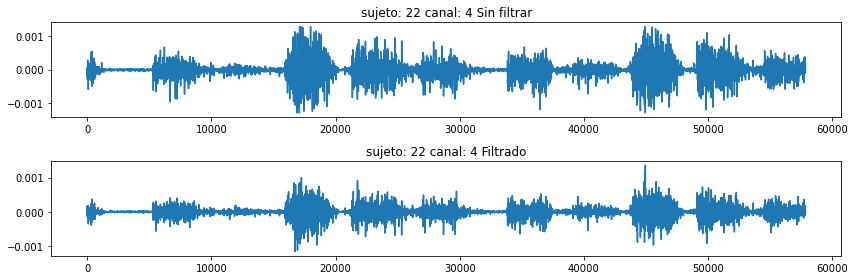

In [39]:
#visualización de señal filtrada y sin filtrar
sujeto=22
canal=4
plt.figure(figsize=(12,4))
plt.subplot(211)
plt.plot(serie2[sujeto-1][:,canal])
plt.title(f'sujeto: {sujeto} canal: {canal} Sin filtrar')
plt.subplot(212)
plt.plot(serie2_filt[sujeto-1][:,canal])
plt.title(f'sujeto: {sujeto} canal: {canal} Filtrado')
plt.tight_layout()

tkeo de filtrada

In [40]:
tkeo_filt=[]
for i in range(0,np.shape(serie2_filt)[0]):
    tkeo_filt.append((tkeoall(serie2_filt[i]))) 

c:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


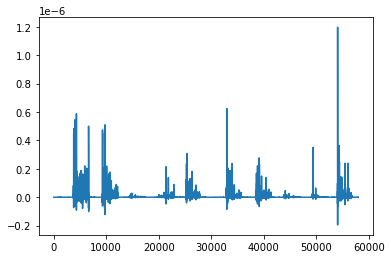

In [42]:
plt.plot(tkeo_filt[0][:,0][1:-1])

separacion de movs con señal filtrada

In [43]:
#Se separa de la señal con tkeo filtrada
movs_filt=[]
for i in range(len(tkeo_filt)):
    movsxsuj=[]
    for mov in range(7):
        mov_type=tkeo_filt[i][serie2[i][:,-1]==mov]
        movsxsuj.append(mov_type) #lista con los 7 movs separados por cada sujeto
    movs_filt.append(movsxsuj) #lista con todos los movs por sujeto

In [44]:
#guardar todos los tipos de movs en la misma lista
mov0_filt=[] 
mov1_filt=[]
mov2_filt=[]
mov3_filt=[]
mov4_filt=[]
mov5_filt=[]
mov6_filt=[]
for suj in movs_filt:
    mov0_filt.append(suj[0])
    mov1_filt.append(suj[1])
    mov2_filt.append(suj[2])
    mov3_filt.append(suj[3])
    mov4_filt.append(suj[4])
    mov5_filt.append(suj[5])
    mov6_filt.append(suj[6])

caracteristicas de señal filtrada

In [46]:
#calculo de caracteristicas promediadas por canales para cada sujeto (y movimiento)
#se ignora mov0 porque es un movimiento sin definir? -> revisar descripcion dataset
caracs1_filt=[]
caracs2_filt=[]
caracs3_filt=[]
caracs4_filt=[]
caracs5_filt=[]
caracs6_filt=[]
for i in range(len(mov1)):
    caracs1_filt.append(np.mean(caracteristicas(mov1_filt[i]),axis=0))
    caracs2_filt.append(np.mean(caracteristicas(mov2_filt[i]),axis=0))
    caracs3_filt.append(np.mean(caracteristicas(mov3_filt[i]),axis=0))
    caracs4_filt.append(np.mean(caracteristicas(mov4_filt[i]),axis=0))
    caracs5_filt.append(np.mean(caracteristicas(mov5_filt[i]),axis=0))
    caracs6_filt.append(np.mean(caracteristicas(mov6_filt[i]),axis=0))
#orden : [xrms,xvar,xmav,xmavs,xssc,xwl,xzc] (columnas)

boxplots

In [82]:
caracs1=np.array(caracs1)
caracs1_filt=np.array(caracs1_filt)
caracs2=np.array(caracs2)
caracs2_filt=np.array(caracs2_filt)
caracs3=np.array(caracs3)
caracs3_filt=np.array(caracs3_filt)
caracs4=np.array(caracs4)
caracs4_filt=np.array(caracs4_filt)
caracs5=np.array(caracs5)
caracs5_filt=np.array(caracs5_filt)
caracs6=np.array(caracs6)
caracs6_filt=np.array(caracs6_filt)

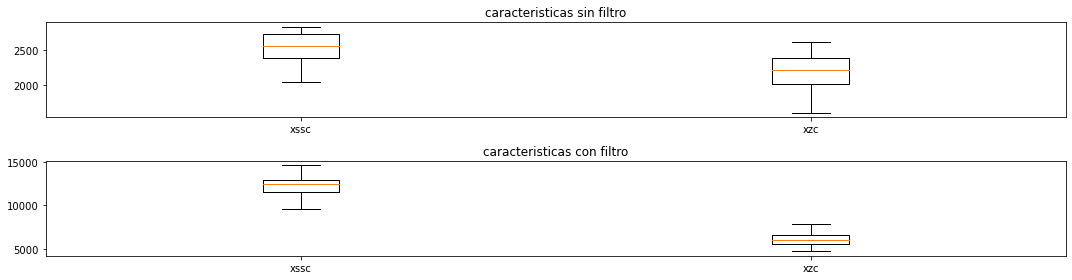

In [68]:
plt.figure(figsize=(15,4))
plt.subplot(211)
plt.boxplot((caracs1[:,4],caracs1[:,6]),showfliers=False)
plt.xticks([1,2],['xssc','xzc'])
plt.title('caracteristicas sin filtro')
plt.subplot(212)
plt.boxplot((caracs1_filt[:,4],caracs1_filt[:,6]),showfliers=False)
plt.xticks([1,2],['xssc','xzc'])
plt.title('caracteristicas con filtro')
plt.tight_layout()

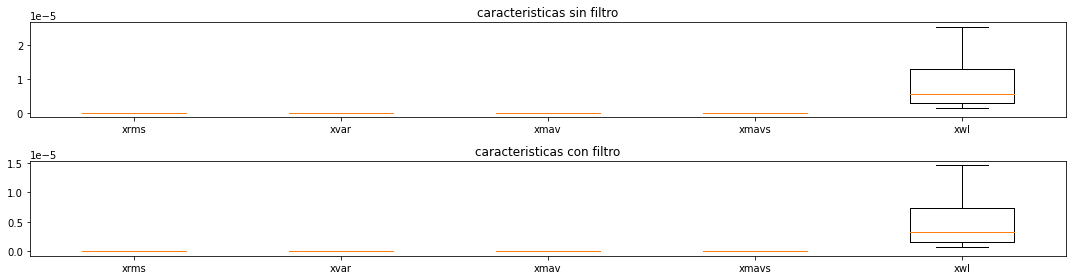

In [69]:
plt.figure(figsize=(15,4))
plt.subplot(211)
plt.boxplot((caracs1[:,0],caracs1[:,1],caracs1[:,2],caracs1[:,3],caracs1[:,5]),showfliers=False)
plt.xticks([1,2,3,4,5],['xrms','xvar','xmav','xmavs','xwl'])
plt.title('caracteristicas sin filtro')
plt.subplot(212)
plt.boxplot((caracs1_filt[:,0],caracs1_filt[:,1],caracs1_filt[:,2],caracs1_filt[:,3],caracs1_filt[:,5]),showfliers=False)
plt.xticks([1,2,3,4,5],['xrms','xvar','xmav','xmavs','xwl'])
plt.title('caracteristicas con filtro')
plt.tight_layout()

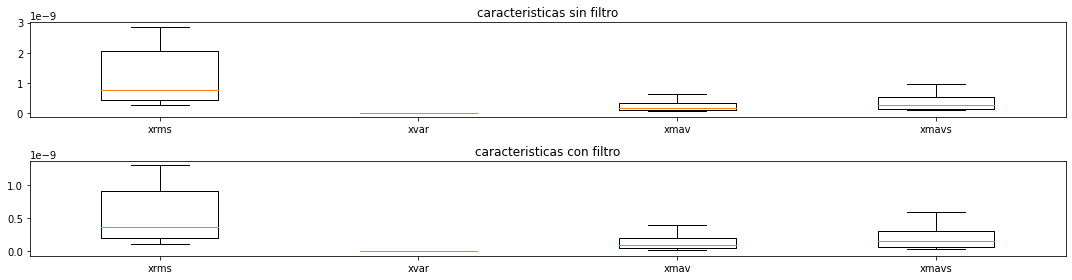

In [72]:
plt.figure(figsize=(15,4))
plt.subplot(211)
plt.boxplot((caracs1[:,0],caracs1[:,1],caracs1[:,2],caracs1[:,3]),showfliers=False)
plt.xticks([1,2,3,4],['xrms','xvar','xmav','xmavs'])
plt.title('caracteristicas sin filtro')
plt.subplot(212)
plt.boxplot((caracs1_filt[:,0],caracs1_filt[:,1],caracs1_filt[:,2],caracs1_filt[:,3]),showfliers=False)
plt.xticks([1,2,3,4],['xrms','xvar','xmav','xmavs'])
plt.title('caracteristicas con filtro')
plt.tight_layout()

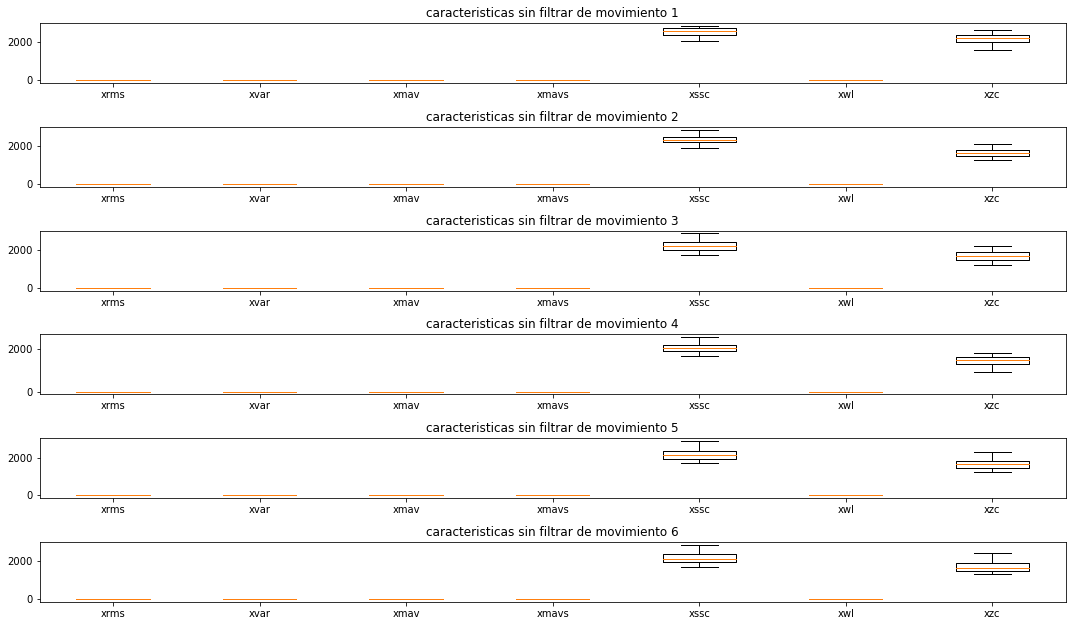

In [90]:
names=['1','2','3','4','5','6','7','8']
caracs=[caracs1,caracs2,caracs3,caracs4,caracs5,caracs6]
plt.figure(figsize=(15,10))
for i in range(len(caracs)):
    plt.subplot(7,1,i+1)
    plt.boxplot((caracs[i][:,0],caracs[i][:,1],caracs[i][:,2],caracs[i][:,3],caracs[i][:,4],caracs[i][:,5],caracs[i][:,6]), showfliers=False) 
    plt.xticks([1,2,3,4,5,6,7],['xrms','xvar','xmav','xmavs','xssc','xwl','xzc'])
    plt.title(f'caracteristicas sin filtrar de movimiento {i+1}')
plt.tight_layout()

In [81]:
#seguir, dependiendo de cuánto se diferencien los boxplots, determinar si sí vale la pena utilizar las señales filtradas
#para los modelos. En caso de que no, es indicio de que los datos (señales) ya vienen muy limpios.

list